In [1]:
import requests
contracts_url = 'https://www.politicalalertengine.com/api/contracts/all'

r = requests.get(contracts_url)

contracts = r.json()

prices_url = 'https://www.politicalalertengine.com/api/analytics/dataByIds/%d'

prices = requests.get(prices_url % 4390).json()

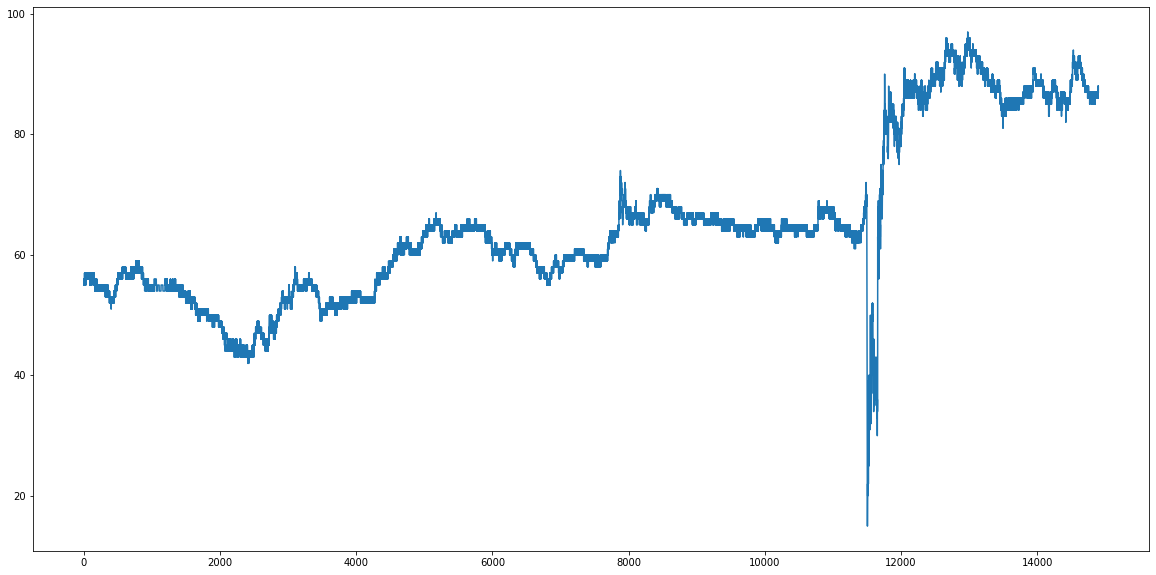

In [2]:
import pandas as pd
df = pd.DataFrame(prices)

import numpy as np
df['date'] = pd.to_datetime(df['date'])
df['lastTradePrice'] = df['lastTradePrice'].astype(np.float64)

c_df = pd.DataFrame(contracts)

c_df[c_df['predictItId'] == 4390]

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,10))
plt.plot(df['lastTradePrice'])

In [3]:
df

,id,predictItId,lastTradePrice,date,lastClose
0,80122,4390,56.0,2019-06-08 03:38:31.926000+00:00,None
1,22715824,4390,55.0,2019-06-09 13:37:46.179000+00:00,None
2,22740420,4390,56.0,2019-06-09 23:35:36.308000+00:00,None
3,22810673,4390,55.0,2019-06-11 03:30:40.709000+00:00,None
4,2592337,4390,56.0,2019-06-11 10:09:38.213000+00:00,None
...,...,...,...,...,...
14894,28121548,4390,87.0,2020-12-01 02:25:57.558000+00:00,None
14895,28121577,4390,88.0,2020-12-01 02:31:57.543000+00:00,None
14896,28121582,4390,87.0,2020-12-01 02:32:53.853000+00:00,None
14897,28121596,4390,88.0,2020-12-01 02:34:54.563000+00:00,None


<Figure size 432x288 with 0 Axes>

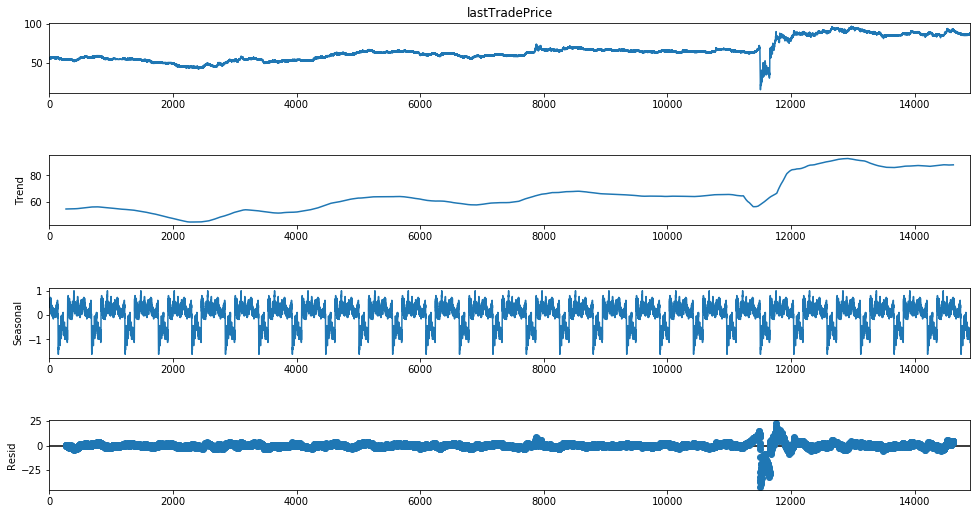

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['lastTradePrice'], period=541)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [5]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['lastTradePrice'])

In [6]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [7]:
adf_check(df['lastTradePrice'])

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.7005449130753703
p-value : 0.43083174314935935
#Lags Used : 39
Number of Observations Used : 14859
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [8]:
df['dateCol'] = df['date']
df= df.set_index('date')


df = df[df.index <= '2020-11-01']

In [9]:
adf_check(df['lastTradePrice'])

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.1276179825993236
p-value : 0.703933471106356
#Lags Used : 20
Number of Observations Used : 10996
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [15]:
df['lastTradePriceDiff'] = df['lastTradePrice'] - df['lastTradePrice'].shift(1)
adf_check(df['lastTradePriceDiff'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -26.596641967371074
p-value : 0.0
#Lags Used : 19
Number of Observations Used : 10996
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


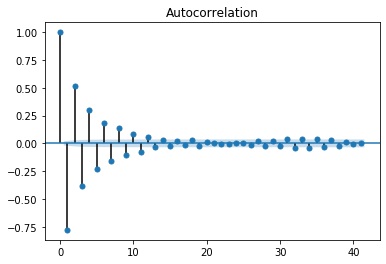

In [17]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
df_diff = plot_acf(df["lastTradePriceDiff"].dropna())

In [24]:
model = ARIMA(df["lastTradePriceDiff"].dropna(), order=(5,1,1))
model_fit = model.fit()
print(model_fit.summary())

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                              ARIMA Model Results                               
Dep. Variable:     D.lastTradePriceDiff   No. Observations:                11015
Model:                   ARIMA(5, 1, 1)   Log Likelihood              -10108.132
Method:                         css-mle   S.D. of innovations              0.606
Date:                  Tue, 01 Dec 2020   AIC                          20232.263
Time:                          11:24:23   BIC                          20290.719
Sample:                               1   HQIC                         20251.955
                                                                                
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         3.7e-07   5.93e-06      0.062      0.950   -1.13e-05     1.2e-05
ar.L1.D.lastTradePriceDiff    -1.0390      0.010   -108.728      0.

In [10]:
daily_px = df.resample('1D',how='mean')
daily_px = daily_px.ffill()
daily_px = daily_px.bfill()

daily_px.index += datetime.timedelta(days=1)

plt.plot(daily_px['lastTradePrice'])

plt.show()

daily_px['ret'] = daily_px['lastTradePrice'].diff()

_ = plt.hist(daily_px['ret'],bins=50)
plt.show()

plt.scatter(daily_px['ret'],daily_px['ret'].shift(-1))
plt.show()

daily_px['ret'].corr(daily_px['ret'].shift(-1))

TypeError: resample() got an unexpected keyword argument 'how'

In [ ]:
#######################
# time of day effects #
#######################

# average/median intraday price movement
plt.locator_params(nbins=10)

g_day = df.groupby(df.index.date)
# g_week = df.groupby(pd.Grouper(key='dateCol',freq='W-MON'))
fig = plt.figure(figsize=(20,10))
price_days = [] 
for n,g in g_day:
    if len(g) < 5:
        continue
#     print(g.columns)
#     g = g.set_index('date')
    g = g.sort_index()
#     print(g)
    g = g.resample('30T', how='mean').interpolate(method='time')
#     print(g)
    midnight = g.index[0].replace(hour=0,minute=0, second=0,microsecond=0)
#     print(pd.date_range(midnight, midnight + datetime.timedelta(hours=23,minutes=59),freq='30T'))
    g = g.reindex(pd.date_range(midnight, midnight + datetime.timedelta(hours=23,minutes=59),freq='30T'))
#     print(g)
#     print(g)
    g = g.bfill()
    g = g.ffill()
    start_price = g['lastTradePrice'].iloc[0]
    
#     xaxis = g.index.time
    xaxis = g.index - g.index[0]
#     print(xaxis)
    
    plt.plot([pd.to_datetime('2020-01-01').normalize() + dt for dt in xaxis],g['lastTradePrice'] - start_price,alpha=0.3)
#     print(len(g['lastTradePrice'].values))
    price_days.append(list(g['lastTradePrice'].values))
plt.ylim((-10,10))

In [ ]:
price_days = np.array(price_days)

In [ ]:
print('expect %d days of data' % (df.index[-1] - df.index[0]).days)

In [ ]:
print('actually %d days of data' % len(price_days))

In [ ]:
price_diffs

In [ ]:
price_diffs = pri

In [ ]:
avg_ret = (price_days[:,-1] - price_days[:,0]).mean()


In [ ]:
# price_chngs = np.diff(price_days,axis=1)
dt = datetime.datetime(2020,1,1).replace(hour=0,minute=0, second=0,microsecond=0)
xaxis = pd.date_range(dt, dt + datetime.timedelta(hours=23,minutes=59),freq='30T').time

price_chngs = (price_days[:,1:] - price_days[:,:-1])
price_chngs -= avg_ret / price_chngs.shape[1]

price_diffs = np.concatenate(([[0]]*len(price_chngs),price_chngs.cumsum(axis=1)),axis=1)
#
# price_diffs = (price_days[:,:].T - price_days[:,0]).T
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)

ax2 = ax1.twinx()
ax1.plot(xaxis,price_diffs.mean(axis=0),label='mean')
ax1.plot(xaxis,np.median(price_diffs,axis=0),label='median')
ax2.plot(xaxis,np.std(price_diffs,axis=0),color='green',label='std')


plt.show()




plt.plot(xaxis[1:], price_chngs.mean(axis=0))
plt.plot(xaxis[1:], price_chngs.std(axis=0))


In [ ]:
# why is standard deviation lower on weekends?

# intraday vol probably lowest from 5:30-10 CST/NYC or so becaus all timezones aree quite late

In [ ]:
price_days.shape

In [ ]:
avg_ret = (price_days[:,-1] - price_days[:,0]).mean()


In [ ]:
# price_chngs = np.diff(price_days,axis=1)

dt = datetime.datetime(2020,1,1).replace(hour=0,minute=0, second=0,microsecond=0)
xaxis = pd.date_range(dt, dt + datetime.timedelta(days=6,hours=23,minutes=59),freq='30T')

price_chngs = (price_days[:,1:] - price_days[:,:-1])
price_chngs -= avg_ret / price_diffs.shape[1]

price_diffs = np.concatenate(([[0]]*len(price_chngs),price_chngs.cumsum(axis=1)),axis=1)
# (price_days[:,:].T - price_days[:,0]).T

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)

ax2 = ax1.twinx()
ax1.plot(xaxis,price_diffs.mean(axis=0),color='blue',label='mean')
ax1.plot(xaxis,np.median(price_diffs,axis=0),color='orange',label='median')
ax2.plot(xaxis,np.std(price_diffs,axis=0),color='green',label='std')

plt.show()




plt.plot(xaxis[1:], price_chngs.mean(axis=0))
plt.plot(xaxis[1:], price_chngs.std(axis=0))


In [ ]:
from scipy.stats import ttest_ind

In [ ]:
friday_start = 144
friday_end = friday_start + 96

friday_chngs = price_chngs[:,friday_start:friday_end].cumsum(axis=1)[:,-1]
print(friday_chngs.mean(), friday_chngs.std())

In [ ]:
daily_px = df.resample('1D',how='mean')
daily_px = daily_px.ffill()
daily_px = daily_px.bfill()

daily_px.index += datetime.timedelta(days=1)

plt.plot(daily_px['lastTradePrice'])

plt.show()

daily_px['ret'] = daily_px['lastTradePrice'].diff()

_ = plt.hist(daily_px['ret'],bins=50)
plt.show()

plt.scatter(daily_px['ret'],daily_px['ret'].shift(-1))
plt.show()

daily_px['ret'].corr(daily_px['ret'].shift(-1))

In [ ]:
import statsmodels.api as sm

In [ ]:
price_diffs.cumsum(axis=1)[:,-1].mean()

In [ ]:
import datetime
day = g_day.get_group(datetime.date(2020,1,1))

In [ ]:
daily_index = pd.date_range("00:01", "23:59", freq="30min").time

# day['lastTradePrice'].reindex(pd.interpolate(method='time')

In [ ]:
df['date'].diff().nlargest(25)